# Multi-label classification
Previously, we classified things into 2 classes: dogs and cats. But what if our image belongs to multiple classes?

The process is largely the same in terms of fast.ai, but there are a few differences.

## 1. Softmax --> Sigmoid
Instead of using a `softmax` activation function to evaluate our classes, we'll use a __sigmoid__ function. Softmax wants to pick one thing -- remember, the $e^{activation}$ means differences between numbers will be greatly accentuated. Sigmoid works better than softmax because it will normalize between 0-1, but it will still allow us to normalize towards multiple classes.

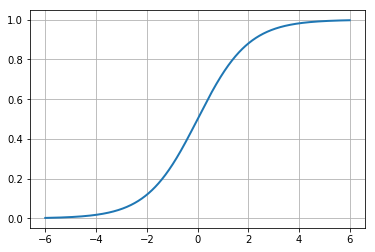

In [1]:
# The sigmoid function aka logistic function
# Sigmoid will be close to 0 when -ve, and close to 1 when +ve
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
    # Apply sigmoid activation function
    return 1/(1+np.exp(-z))

test_input = np.arange(-6, 6, 0.01)
plt.plot(test_input, sigmoid(test_input), linewidth=2)
plt.grid(1)

## 2. Read from CSV
In our previous function, we were able to use a keras-style set up -- put each class in a folder with that class name. Since each image can belong to multiple classes, we'd have to copy each image to multiple folders, which isn't really practical or optimal. So instead we must read our data from a .csv file.

## Note on one-hot encoding
In single classification, our data might be one-hot encoded. Imagine we have a bunch of data like this:

In [2]:
# The second row indicates which class our data is -- there is a 1 in the column that represents the data
data = np.array([["Dog", "Cat", "Frog", "Bird"],
                 [0, 0, 1, 0]])
data

array([['Dog', 'Cat', 'Frog', 'Bird'],
       ['0', '0', '1', '0']], dtype='<U4')

Obviously it would be a lot more efficient to just enumerate the data:

In [6]:
data = np.array([["Dog", "Cat", "Frog", "Bird"],
                 [0, 1, 2, 3]])
data

array([['Dog', 'Cat', 'Frog', 'Bird'],
       ['0', '1', '2', '3']], dtype='<U4')

So if our data is tagged with `2` we know it's a frog, etc. Note that even if our data is tagged like this, `PyTorch` will turn it into one-hot encoded vectors.

More info: https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

# Doing the training

In [3]:
# First import our data
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.conv_learner import *

In [5]:
PATH = 'data/planet/'

In [6]:
!ls {PATH}

__MACOSX  models  test-jpg  tmp  train-jpg  train_v2.csv


In [7]:
# Recall from previous lessons that we had our confusion matrix showing false negatives, false positives, etc.
# f2 is a function defined by the contest to measure how good our function is. You can always define your own evaluation function.

from planet import f2

metrics=[f2]
f_model = resnet34

In [8]:
label_csv = f'{PATH}train_v2.csv'
data_size = len(list(open(label_csv)))-1

# Generate some data to use as validation data by taking some random rows (20%)
val_idxs = get_cv_idxs(data_size)

In [9]:
# Set up our get_data function
# This sets up our transforms and returns an image classifier which we can use to browse data, etc.
# Notice this time we can set top-down transforms since we're using satellite data
def get_data(image_size):
    transforms = tfms_from_model(f_model, image_size, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, "train-jpg", label_csv, tfms=transforms, 
                                        suffix=".jpg", val_idxs=val_idxs, test_name="test-jpg")

In [10]:
# Now set up our data using the function we just defined
data = get_data(256)

Now we will explore our data some more. There are a few concepts from `PyTorch` that it's worth knowing about:

* `Data set` (ds) = a single object (e.g., a single image)
* `Data loader` (dl) = a single mini-batch (e.g., of images)

In [11]:
# So this line of code will get a single mini-batch, convert it to an iterator, and then get the next item from that iterator
images,labels = next(iter(data.val_dl))

In [12]:
# We can see that we have a list of vectors with a 1 where they should have that classification label
labels


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [13]:
# Note too the shape
# The batch size is 64, and we have 17 different labels
labels.shape

torch.Size([64, 17])

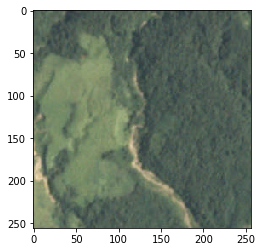

In [14]:
# Let's take a look at the first image
# Note, because the image is just a matrix of numbers, we can *1.4 to make it brighter
plt.imshow(data.val_ds.denorm(to_np(images))[0]*1.4);

In [15]:
# And to see which labels this has
list(zip(data.classes, labels[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

In [16]:
# Start off training on small images
image_size=64

In [17]:
data = get_data(image_size)

In [18]:
# This goes through and resizes all of our images for efficiencies sake?
data = data.resize(int(image_size*1.3), "tmp")

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [20]:
# Now we want to find the learning rate
# First set up our model
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.220537   0.422463   0.789931  



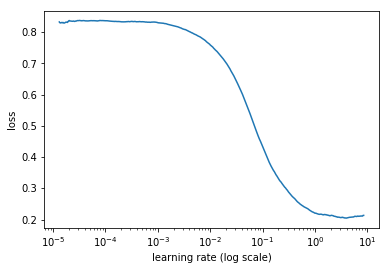

In [47]:
learning_rate_finder = learn.lr_find()
learn.sched.plot()

In [22]:
# Note that the learning rate is decreasing fastest at around 0.2
learning_rate = 0.2

In [23]:
# Do some training for the final layers
# We now know that when we train, what we are doing is setting the kernel (image feature filter) values
# and the numbers of the weight matrix in the fully connected layer
learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.14736    0.13469    0.879414  
    1      0.142267   0.129391   0.885923                    
    2      0.138263   0.127576   0.887258                    
    3      0.140281   0.126938   0.888762                    
    4      0.137914   0.124001   0.890997                    
    5      0.131529   0.123408   0.893647                    
    6      0.130181   0.12329    0.891949                    



[0.12329047, 0.8919489753927757]

In [24]:
# The satellite images are quite different from the image-net images that this network was trained on
# Therefore, we use slightly higher learning rates than our cats/dogs examples to train the network
differential_learning_rates = np.array([learning_rate/9, learning_rate/3, learning_rate])

In [26]:
# Unfreeze the previous layers so we can train them with our differential learning rates
learn.unfreeze()
learn.fit(differential_learning_rates, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.120932   0.108382   0.909156  
    1      0.115432   0.105932   0.909191                    
    2      0.105167   0.10103    0.915758                    
    3      0.111772   0.102488   0.91311                     
    4      0.105998   0.100651   0.915267                    
    5      0.101719   0.09802    0.916691                     
    6      0.098998   0.097133   0.917914                     



[0.09713308, 0.91791370766977]

In [27]:
# Save the weights
learn.save(f'{image_size}')

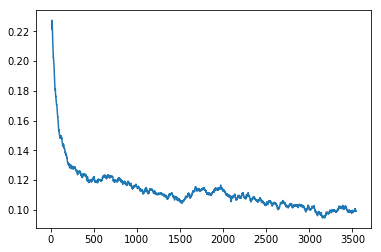

In [28]:
# Take a look -- we can see the loss decreasing as we train
learn.sched.plot_loss()

In [29]:
# Now we train again with slightly larger images
# Still not 100% sure what the reason for this is -- just simulating different data?
image_size = 128

In [30]:
data = get_data(image_size)
learn.set_data(data)
learn.freeze()
learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=13), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.098714   0.096537   0.917149  
    1      0.100112   0.095297   0.919537                     
    2      0.095763   0.094022   0.920467                     
    3      0.095169   0.093924   0.919777                     
    4      0.098707   0.09404    0.921207                     
    5      0.097631   0.093178   0.921026                     
    6      0.095902   0.093244   0.920144                     
    7      0.093888   0.092771   0.921678                     
    8      0.092554   0.092677   0.921674                     
    9      0.09418    0.091928   0.922913                     
    10     0.092501   0.091704   0.922293                     
    11     0.091666   0.091564   0.922321                     
    12     0.090078   0.091956   0.921488                     



[0.09195557, 0.9214877960864891]

In [31]:
# Now tweak the initial layers again
learn.unfreeze()
learn.fit(differential_learning_rates, 3, cycle_len=1, cycle_mult=3)

HBox(children=(IntProgress(value=0, description='Epoch', max=13), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.092793   0.087805   0.927363  
    1      0.09623    0.088546   0.925771                     
    2      0.091078   0.086233   0.92801                      
    3      0.087241   0.085489   0.9284                       
    4      0.095144   0.089547   0.926124                     
    5      0.090785   0.087691   0.926577                     
    6      0.087424   0.086907   0.926908                     
    7      0.086251   0.086164   0.926724                     
    8      0.082321   0.085769   0.92639                      
    9      0.080621   0.084496   0.929468                     
    10     0.080943   0.084145   0.929588                     
    11     0.075996   0.084212   0.929369                     
    12     0.077381   0.084321   0.9293                       



[0.08432135, 0.9292995924747179]

In [32]:
learn.save(f'{image_size}')

In [33]:
# Now do it AGAIN, with even bigger image sizes
image_size = 256

In [35]:
data = get_data(image_size)
learn.set_data(data)
learn.freeze()
learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.091138   0.090089   0.924436  
    1      0.089965   0.089359   0.925116                     
    2      0.08823    0.089175   0.926036                     
    3      0.088119   0.088418   0.926243                     
    4      0.085408   0.088381   0.927063                     
    5      0.085668   0.088337   0.926008                     
    6      0.086202   0.087519   0.927309                     



[0.0875194, 0.9273087637207408]

In [36]:
# (Interrupted the kernel here as it started running for 21 cycles for some reason. fasi.ai bug?)
learn.unfreeze()
learn.fit(differential_learning_rates, 3, cycle_len=3, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=21), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.085767   0.083354   0.932566  
    1      0.08356    0.081909   0.93292                      
    2      0.078167   0.080999   0.932661                     
    3      0.086357   0.083911   0.930388                     
    4      0.083617   0.083095   0.93072                      
    5      0.081474   0.083832   0.927965                     
    6      0.076187   0.08217    0.93121                      
    7      0.075701   0.081892   0.932569                     
 34%|███▍      | 174/506 [03:31<06:43,  1.22s/it, loss=0.0751]

KeyboardInterrupt: 

In [37]:
learn.save(f'{image_size}')

In [38]:
# Finallly, get our predictions using test time augmentation
# Reminder: TTA = Test Time Augmentation, applying transforms to the test data and taking an average
multi_label_classification_predictions,target_values = learn.TTA()

In [39]:
predictions = np.mean(multi_label_classification_predictions, 0)

In [44]:
# Predictions contains the likelihood for each of our 17 classes
predictions[:5]

array([[0.76759, 0.0016 , 0.02022, 0.00089, 0.00083, 0.99982, 0.00006, 0.00021, 0.43698, 0.02853, 0.00011,
        0.00003, 0.99958, 0.22834, 0.00342, 0.01352, 0.73973],
       [0.18095, 0.00006, 0.00077, 0.00014, 0.00077, 0.00035, 0.00022, 0.00009, 0.02922, 0.00091, 0.00005,
        0.99785, 0.99984, 0.01146, 0.0006 , 0.001  , 0.05649],
       [0.99405, 0.00013, 0.01334, 0.00012, 0.00006, 0.99976, 0.00001, 0.00005, 0.09454, 0.1095 , 0.00048,
        0.00003, 0.99309, 0.9827 , 0.00023, 0.00075, 0.07534],
       [0.01294, 0.9995 , 0.04651, 0.00125, 0.0003 , 0.99966, 0.00012, 0.03368, 0.00482, 0.02961, 0.00009,
        0.00026, 0.96083, 0.30619, 0.00502, 0.00017, 0.99083],
       [0.99758, 0.00004, 0.00231, 0.00024, 0.00009, 0.99609, 0.00003, 0.00016, 0.11167, 0.79664, 0.00222,
        0.00135, 0.97242, 0.99619, 0.00044, 0.00086, 0.0222 ]], dtype=float32)

In [45]:
# Target values contains the actual correct classes for each image
target_values[:5]

array([[1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]], dtype=float32)

In [40]:
f2(predictions, target_values)

0.9308049768554749

# Note on structured/unstructured data
In the next lesson, we will look at processing structured and unstructed data.

These are not 100% standardized terms, but generally we think of it as:

1. __Unstructured data__: Every "piece" of the data objects we're processing is the same. For example, in an image, everything is a pixel.

2. __Structured data__: The parts of the data objects are different. For example, if we are processing sales reports, one column could contain profit, another weather data, another quarterly dates, etc.